In [22]:
import os
import numpy as np
import hdf5storage
import cv2
import matlab
import matlab.engine
from PnP_restoration.utils.utils_restoration import single2uint,crop_center, matlab_style_gauss2D, imread_uint, imsave
from scipy import ndimage
from PIL import Image

def CalMATLAB(IRFolder,GTFolder):
    eng = matlab.engine.start_matlab()
    eng.addpath(eng.genpath(eng.fullfile(os.getcwd(),'Metrics')))
    res = eng.evaluate_PSNR(IRFolder,GTFolder)
    res=np.array(res)
    return res

def CalMATLAB2(IRFolder,one_gt_name):
    eng = matlab.engine.start_matlab()
    eng.addpath(eng.genpath(eng.fullfile(os.getcwd(),'Metrics')))
    res = eng.evaluate_PSNR_comparison(IRFolder,one_gt_name)
    res=np.array(res)
    return res

def MATLAB_imresize(imgname, Sf=3):
    eng = matlab.engine.start_matlab()
    x = eng.load(imgname)['data']
#     eng.addpath(eng.genpath(eng.fullfile(os.getcwd(),'Metrics')))
    res = eng.imresize(x, Sf)
    res=np.array(res)
    return res

def MATLAB_imresize2(imgname, Sf=3):
    eng = matlab.engine.start_matlab()
    x = eng.imread(imgname)
#     eng.addpath(eng.genpath(eng.fullfile(os.getcwd(),'Metrics')))
    res = eng.imresize(x, Sf)
    res=np.array(res)
    return res


def MATLAB_degradation(imgname, Sf=3):
    eng = matlab.engine.start_matlab()
    x = eng.imread(imgname)
    x = matlab.double(x)
#     eng.addpath(eng.genpath(eng.fullfile(os.getcwd(),'Metrics')))
    res = eng.imresize(x, Sf)
    res=np.array(res)
    return res


def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def norm_proj(x):
    x = (x-np.min(x))/(np.max(x)-np.min(x))
    return x

def imsave(img, img_path):
    if img.ndim == 3:
        img = img[:, :, [2, 1, 0]]
    cv2.imwrite(img_path, img)
    
def numpy_degradation(x, k, sf=3):
    ''' blur + downsampling
    Args:
        x: HxWxC image, [0, 1]/[0, 255]
        k: hxw, double, positive
        sf: down-scale factor
    Return:
        downsampled LR image
    '''
    x = ndimage.filters.convolve(x, np.expand_dims(k, axis=2), mode='wrap')
    # x = filters.correlate(x, np.expand_dims(np.flip(k), axis=2))
    st = 0
    return x[st::sf, st::sf, ...]


In [23]:
kernel_path = os.path.join('PnP_restoration/kernels', 'Levin09.mat')
kernels = hdf5storage.loadmat(kernel_path)['kernels']
name = 'hat'###bike, butterfly,flower, girl, hat,parrots
k_index = 9
Sf = 1
task = 'Gaussian-blurring'##Gaussian-blurring;uniform-blurring
img_type = 'RGB'
noise_level = 8#
algorithm = 'RED_PRO'#################################SAM_PROv1, RED, RED_PRO, PnP_FBS##################################
if task == 'uniform-blurring': # Uniform blur
    k = (1/81)*np.ones((9,9))
elif task == 'Gaussian-blurring':  # Gaussian blur
    k = matlab_style_gauss2D(shape=(25,25),sigma=1.6)
else: # Motion blur
    k = kernels[0, k_index]
if img_type == 'RGB':
    input_im_uint = imread_uint('test_images/'+name+'.tif',n_channels=3)
#     input_im_uint = imread_uint('datasets/set12/05.png', n_channels=3)
else:
    input_im_uint = imread_uint('test_images/'+name+'.tif',n_channels=1)
#     input_im_uint = imread_uint('datasets/set12/05.png', n_channels=1)
input_im = np.float32(input_im_uint / 255)
            # Degrade image
if Sf>1:#super-resolution
    blur_im = numpy_degradation(input_im, k, sf=Sf)
else:# debluring
    blur_im = ndimage.filters.convolve(input_im, np.expand_dims(k, axis=2), mode='wrap')
np.random.seed(seed=0)
noise = np.random.normal(0, noise_level / 255., blur_im.shape)
blur_im += noise
init_im = blur_im

/tmp/ipykernel_44058/2321125391.py:27: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  blur_im = ndimage.filters.convolve(input_im, np.expand_dims(k, axis=2), mode='wrap')


(256, 256, 3) (256, 256, 3)


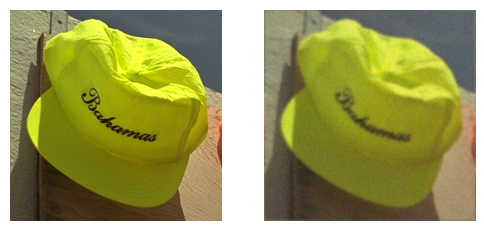

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,16))
if img_type == 'RGB':
    ax[0].imshow(input_im_uint)
    # ax[0].set_title('Input image')
    ax[0].set_axis_off()
    ax[1].imshow(np.uint8(norm_proj(init_im)*255))
    # ax[1].set_title('Dice loss')
    ax[1].set_axis_off()
else:
    ax[0].imshow(input_im,cmap='Greys_r')
    # ax[0].set_title('Input image')
    ax[0].set_axis_off()
    ax[1].imshow(init_im, cmap='Greys_r')
    # ax[1].set_title('Dice loss')
    ax[1].set_axis_off()
print(input_im_uint.shape,init_im.shape)

In [25]:
import torch
import torch.nn as nn
from PnP_restoration.utils.utils_restoration import rgb2y, psnr, array2tensor, tensor2array
from PnP_restoration.utils import utils_sr
from utils.utils import load_model
from utils.utils import psnr
from utils.config import analyze_parse
import math

def initialize_prox(img, degradation_mode, degradation, sf, device):
#     degradation_mode = degradation
    if degradation_mode == 'deblurring':
        k = degradation
        k_tensor = array2tensor(np.expand_dims(k, 2)).double().to(device)
        FB, FBC, F2B, FBFy = utils_sr.pre_calculate_prox2(img, k_tensor, sf)
        return FB, FBC, F2B, FBFy, k_tensor
    elif degradation_mode == 'SR':
        k = degradation
        k_tensor = array2tensor(np.expand_dims(k, 2)).double().to(device)
        FB, FBC, F2B, FBFy = utils_sr.pre_calculate_prox2(img,k_tensor, sf)
        return FB, FBC, F2B, FBFy, k_tensor
    elif degradation_mode == 'inpainting':
        M = array2tensor(degradation).double().to(device)
        My = M*img
        return My
    else:
        print('degradation mode not treated')

def calulate_data_term(k_tensor,degradation_mode, sf,y,img):
        '''
        Calculation of the data term value f(y)
        :param y: Point where to evaluate F
        :param img: Degraded image
        :return: f(y)
        '''
#         k_tensor = array2tensor(np.expand_dims(k, 2)).double().to(device)
        if degradation_mode == 'deblurring':
            deg_y = utils_sr.imfilter(y.double(), k_tensor[0].double().flip(1).flip(2).expand(3, -1, -1, -1))
            f = 0.5 * torch.norm(img - deg_y, p=2) ** 2
        elif degradation_mode == 'SR':
            deg_y = utils_sr.imfilter(y.double(), k_tensor[0].double().flip(1).flip(2).expand(3, -1, -1, -1))
            deg_y = deg_y[..., 0::sf, 0::sf]
            f = 0.5 * torch.norm(img - deg_y, p=2) ** 2
#         elif degradation_mode == 'inpainting':
#             deg_y = M * y.double()
#             f = 0.5 * torch.norm(img - deg_y, p=2) ** 2
        else:
            print('degradation not implemented')
        return f
        
def rgb2ycbcr(img, only_y=True):
    '''same as matlab rgb2ycbcr
    only_y: only return Y channel
    Input:
        uint8, [0, 255]
        float, [0, 1]
    '''
    in_img_type = img.dtype
    img.astype(np.float32)
    if in_img_type != np.uint8:
        img *= 255.
    # convert
    if only_y:
        rlt = np.dot(img, [65.481, 128.553, 24.966]) / 255.0 + 16.0
    else:
        rlt = np.matmul(img, [[65.481, -37.797, 112.0], [128.553, -74.203, -93.786],
                              [24.966, 112.0, -18.214]]) / 255.0 + [16, 128, 128]
    if in_img_type == np.uint8:
        rlt = rlt.round()
    else:
        rlt /= 255.
    return rlt.astype(in_img_type)


def ycbcr2rgb(img):
    '''same as matlab ycbcr2rgb
    Input:
        uint8, [0, 255]
        float, [0, 1]
    '''
    in_img_type = img.dtype
    img.astype(np.float32)
    if in_img_type != np.uint8:
        img *= 255.
    # convert
    rlt = np.matmul(img, [[0.00456621, 0.00456621, 0.00456621], [0, -0.00153632, 0.00791071],
                          [0.00625893, -0.00318811, 0]]) * 255.0 + [-222.921, 135.576, -276.836]
    rlt = np.clip(rlt, 0, 255)
    if in_img_type == np.uint8:
        rlt = rlt.round()
    else:
        rlt /= 255.
    return rlt.astype(in_img_type)

def single2uint(img):
    return np.uint8(img*255.)

def tensor2uint(img):
    img = img.data.squeeze().float().clamp_(0, 1).cpu().numpy()
    if img.ndim == 3:
        img = np.transpose(img, (1, 2, 0))
    return np.uint8((img*255.0).round())

def tensor2uint2(img):
    img = img.data.squeeze().float().cpu().numpy()
    img = norm_proj(img)
    if img.ndim == 3:
        img = np.transpose(img, (1, 2, 0))
    return np.uint8((img*255.0).round())

def tensor2float(img):
    img = img.data.squeeze().float().clamp_(0, 1).cpu().numpy()
    if img.ndim == 3:
        img = np.transpose(img, (1, 2, 0))
    return img

def tensor2float2(img):
    img = img.data.squeeze().float().cpu().numpy()
    img = norm_proj(img)
    if img.ndim == 3:
        img = np.transpose(img, (1, 2, 0))
    return img
    
def calculate_psnr(img1, img2, border=0):
    # img1 and img2 have range [0, 255]
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    h, w = img1.shape[:2]
    img1 = img1[border:h-border, border:w-border]
    img2 = img2[border:h-border, border:w-border]

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255.0 /np.sqrt(mse))

def calculate_grad(img, degradation_mode, FB, FBC,FBFy,sf=1):
    if degradation_mode == 'deblurring':
        grad = utils_sr.grad_solution2(img.double(), FB, FBC, FBFy, 1)
    if degradation_mode == 'SR' :
        grad = utils_sr.grad_solution2(img.double(), FB, FBC, FBFy, sf)
    return grad

def load_model(model_type, sigma):
    path = "Pretrained_models/" + model_type + "_noise" + str(sigma) + ".pth"
    if model_type == "DnCNN":
        from model.models import DnCNN
        net = DnCNN(channels=1, num_of_layers=17)
        model = nn.DataParallel(net).cuda()
    elif model_type == "SimpleCNN":
        from model.SimpleCNN_models import DnCNN
        model = DnCNN(1, num_of_layers = 4, lip = 0.0, no_bn = True).cuda()
    elif model_type == "RealSN_DnCNN":
        from model.realSN_models import DnCNN
        net = DnCNN(channels=1, num_of_layers=17)
        model = nn.DataParallel(net).cuda()
    elif model_type == "RealSN_SimpleCNN":
        from model.SimpleCNN_models import DnCNN
        model = DnCNN(1, num_of_layers = 4, lip = 1.0, no_bn = True).cuda()
    else:
        from model.realSN_models import DnCNN
        net = DnCNN(channels=1, num_of_layers=17)
        model = nn.DataParallel(net).cuda()

    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [26]:
def jiasu_hsd_proj_obj_fun2(x0,y, k_tensor, degradation_mode, FB, FBC, FBFy, f, opt):
    K = opt['K']
    alpha = opt['alpha']
    beta = opt['beta']
    sigma = opt['sigma']
    mu_0 = opt['mu_0']
    Sf = opt['sf']
#     y = x0.clone()
#     print(Sf)
    obj_fun = np.zeros(K)
    residual = torch.zeros(K)
    for i in range(K):
        x = x0
        mu_k = mu_0*(i+1)**(-1.0)
        mu = mu_k if mu_k<1 else 1
        ####### T_beta
#         grad1 =  calculate_grad(v_est, degradation_mode, FB, FBC, FBFy, sf=Sf)
        grad1 =  calculate_grad(x, degradation_mode, FB, FBC, FBFy, sf=Sf)
        f_est = x - alpha*grad1/sigma
#         f_est = x
        mintmp = torch.min(f_est)
        maxtmp = torch.max(f_est)
        xtilde = (f_est - mintmp) / (maxtmp - mintmp)
#         xtilde = f_est.clamp_(0, 1)
        #         xtilde = max(min(xtl))
        #         index = 0<=xtilde& xtilde<=1
        #         xtilde = xtilde
        scale_range = 1.0 + sigma/255.0/2.0
        scale_shift = (1 - scale_range) / 2.0
        xtilde = xtilde * scale_range + scale_shift
        r = f(xtilde.float())
        z = xtilde - r
#         z = z.clamp_(0, 1)
        z= (z - scale_shift) / scale_range
        z = z * (maxtmp - mintmp) + mintmp
#         xtilde = f_est.clamp_(0, 1)
#         r = f(xtilde.float())
#         z= xtilde - r
#         z = (1-beta)*f_est+beta*z
        grad =  calculate_grad(z, degradation_mode, FB, FBC, FBFy, sf=Sf)
        v_est = z - mu*grad/sigma
        w = v_est
        
#         print(torch.norm(w-x0, p=2))
        residual[i] = torch.norm(w-x0, p=2)
#         r0 = residual.float().cpu().numpy()
#         print(residual)
        x0 = w
        ########
        obj_fun[i] = calulate_data_term(k_tensor,degradation_mode, Sf,x0,y).float().cpu().numpy()
    return x0, obj_fun, residual.float().cpu().numpy()

def SAM_PRO_v2(x0,y, k_tensor, degradation_mode, FB, FBC, FBFy, f, opt):
    K = opt['K']
    alpha = opt['alpha']
    beta = opt['beta']
    sigma = opt['sigma']
    mu_0 = opt['mu_0']
    Sf = opt['sf']
    obj_fun = np.zeros(K)
    residual = torch.zeros(K)
    for i in range(K):
        x = x0
        mu_k = mu_0*(i+1)**(-1.0)
        mu = mu_k if mu_k<1 else 1
        f_est = x
        mintmp = torch.min(f_est)
        maxtmp = torch.max(f_est)
        xtilde = (f_est - mintmp) / (maxtmp - mintmp)
        scale_range = 1.0 + sigma/255.0/2.0
        scale_shift = (1 - scale_range) / 2.0
        xtilde = xtilde * scale_range + scale_shift
        r = f(xtilde.float())
        z= xtilde - r
        z= (z - scale_shift) / scale_range
        z = z * (maxtmp - mintmp) + mintmp
        z = (1-beta)*f_est+beta*z
        grad =  calculate_grad(z, degradation_mode, FB, FBC, FBFy, sf=Sf)
        v_est = z - mu*grad/sigma
        w = v_est
        residual[i] = torch.norm(w-x0, p=2)
        x0 = w
        obj_fun[i] = calulate_data_term(k_tensor,degradation_mode, Sf,x0,y).float().cpu().numpy()
    return x0, obj_fun, residual.float().cpu().numpy()

def RED(x0,y, k_tensor, degradation_mode, FB, FBC, FBFy, f, opt):
    K = opt['K']
    alpha = opt['alpha']
    beta = opt['beta']
    lambdaa = opt['lambda']
    sigma = opt['sigma']
    input_sigma = opt['input_sigma']
    Sf = opt['sf']
    obj_fun = np.zeros(K)
    residual = torch.zeros(K)
    mu = 1####### 0.1 for parrots(sacle =3, sigma=5;super-resolution); 1 for butterfly(sigma=8, uniform PSF)
    for i in range(K):
        x = x0
        ####### T_beta
#         grad1 =  calculate_grad(v_est, degradation_mode, FB, FBC, FBFy, sf=Sf)
        grad1 =  calculate_grad(x, degradation_mode, FB, FBC, FBFy, sf=Sf)/sigma
        f_est = x 
#         f_est = x
        mintmp = torch.min(f_est)
        maxtmp = torch.max(f_est)
        xtilde = (f_est - mintmp) / (maxtmp - mintmp)
#         xtilde = f_est.clamp_(0, 1)
        #         xtilde = max(min(xtl))
        #         index = 0<=xtilde& xtilde<=1
        #         xtilde = xtilde
        scale_range = 1.0 + sigma/255.0/2.0
        scale_shift = (1 - scale_range) / 2.0
        xtilde = xtilde * scale_range + scale_shift
        r = f(xtilde.float())
        z = xtilde - r
#         z = z.clamp_(0, 1)
        z= (z - scale_shift) / scale_range
        z = z * (maxtmp - mintmp) + mintmp
        grad2 =  (x - z)
        v_est = x - mu*(grad1/sigma+lambdaa*grad2)
        w = v_est
        
#         print(torch.norm(w-x0, p=2))
        residual[i] = torch.norm(w-x0, p=2)
#         r0 = residual.float().cpu().numpy()
#         print(residual)
        x0 = w
        ########
#         obj_fun[i] = calulate_data_term(k_tensor,degradation_mode, Sf,x0,y).float().cpu().numpy()
        x_square = torch.norm(x0, p=2)**2
        obj_fun[i] = 1/sigma*calulate_data_term(k_tensor,degradation_mode, Sf,x0,y).float().cpu().numpy()/x_square.float().cpu().numpy()
    return x0, obj_fun, residual.float().cpu().numpy()

def REDPRO(x0,y, k_tensor, degradation_mode, FB, FBC, FBFy, f, opt):
    K = opt['K']
    alpha = opt['alpha']
    beta = opt['beta']
    lambdaa = opt['lambda']
    sigma = opt['sigma']
    input_sigma = opt['input_sigma']
    Sf = opt['sf']
    obj_fun = np.zeros(K)
    residual = torch.zeros(K)
    for i in range(K):
        x = x0
        mu =alpha*(i+1)**(-0.1)################# 2 for parrots(sacle =3, super-resolution); 4 for butterfly(sigma=8, uniform PSF) and 6 for Hat (sigma=8, Gausian blur)
        ####### T_beta
#         grad1 =  calculate_grad(v_est, degradation_mode, FB, FBC, FBFy, sf=Sf)
        grad1 =  calculate_grad(x, degradation_mode, FB, FBC, FBFy, sf=Sf)
        f_est = x - mu*grad1/sigma
#         f_est = x
        mintmp = torch.min(f_est)
        maxtmp = torch.max(f_est)
        xtilde = (f_est - mintmp) / (maxtmp - mintmp)
#         xtilde = f_est.clamp_(0, 1)
        #         xtilde = max(min(xtl))
        #         index = 0<=xtilde& xtilde<=1
        #         xtilde = xtilde
        scale_range = 1.0 + sigma/255.0/2.0
        scale_shift = (1 - scale_range) / 2.0
        xtilde = xtilde * scale_range + scale_shift
        r = f(xtilde.float())
        z = xtilde - r
#         z = z.clamp_(0, 1)
        z= (z - scale_shift) / scale_range
        z = z * (maxtmp - mintmp) + mintmp
        v_est = beta*z+(1-beta)*f_est
        w = v_est
        
#         print(torch.norm(w-x0, p=2))
        residual[i] = torch.norm(w-x0, p=2)
#         r0 = residual.float().cpu().numpy()
#         print(residual)
        x0 = w
        ########
#         obj_fun[i] = calulate_data_term(k_tensor,degradation_mode, Sf,x0,y).float().cpu().numpy()
        x_square = torch.norm(x0, p=2)**2
        obj_fun[i] = 1/sigma*calulate_data_term(k_tensor,degradation_mode, Sf,x0,y).float().cpu().numpy()/x_square.float().cpu().numpy()
    return x0, obj_fun, residual.float().cpu().numpy()

def PnP_FBS(x0,y, k_tensor, degradation_mode, FB, FBC, FBFy, f, opt):
    K = opt['K']
    alpha = opt['alpha']
    beta = opt['beta']
    lambdaa = opt['lambda']
    sigma = opt['sigma']
    input_sigma = opt['input_sigma']
    Sf = opt['sf']
    obj_fun = np.zeros(K)
    residual = torch.zeros(K)
    mu0 = 4
    for i in range(K):
        x = x0
        mu = mu0################# 2 for parrots(sacle =3, super-resolution); 4 for butterfly(sigma=8, uniform PSF)
        ####10 for hat (sigma=8, gaussian PSF)
        ####### T_beta
#         grad1 =  calculate_grad(v_est, degradation_mode, FB, FBC, FBFy, sf=Sf)
        grad1 =  calculate_grad(x, degradation_mode, FB, FBC, FBFy, sf=Sf)
        f_est = x - mu*grad1/sigma
#         f_est = x
        mintmp = torch.min(f_est)
        maxtmp = torch.max(f_est)
        xtilde = (f_est - mintmp) / (maxtmp - mintmp)
#         xtilde = f_est.clamp_(0, 1)
        #         xtilde = max(min(xtl))
        #         index = 0<=xtilde& xtilde<=1
        #         xtilde = xtilde
        scale_range = 1.0 + sigma/255.0/2.0
        scale_shift = (1 - scale_range) / 2.0
        xtilde = xtilde * scale_range + scale_shift
        r = f(xtilde.float())
        z = xtilde - r
#         z = z.clamp_(0, 1)
        z= (z - scale_shift) / scale_range
        z = z * (maxtmp - mintmp) + mintmp
        v_est = beta*z+(1-beta)*x
        w = v_est
        
#         print(torch.norm(w-x0, p=2))
        residual[i] = torch.norm(w-x0, p=2)
#         r0 = residual.float().cpu().numpy()
#         print(residual)
        x0 = w
        ########
#         obj_fun[i] = calulate_data_term(k_tensor,degradation_mode, Sf,x0,y).float().cpu().numpy()
        x_square = torch.norm(x0, p=2)**2
        obj_fun[i] = 1/sigma*calulate_data_term(k_tensor,degradation_mode, Sf,x0,y).float().cpu().numpy()/x_square.float().cpu().numpy()
    return x0, obj_fun, residual.float().cpu().numpy()

def jiasu_hsd_proj_obj_fun_mat(x0,y, k_tensor, degradation_mode, FB, FBC, FBFy, f, opt):
    K = opt['K']
    alpha = opt['alpha']
    beta = opt['beta']
    sigma = opt['sigma']
    mu_0 = opt['mu_0']
    Sf = opt['sf']
#     y = x0.clone()
#     print(Sf)
    obj_fun = np.zeros(K)
    residual = torch.zeros(K)
    for i in range(K):
        x = x0
        mu_k = mu_0*(i+1)**(-1.0)
        mu = mu_k if mu_k<1 else 1
        ####### T_beta
#         grad1 =  calculate_grad(v_est, degradation_mode, FB, FBC, FBFy, sf=Sf)
#         grad1 =  calculate_grad(x, degradation_mode, FB, FBC, FBFy, sf=Sf)
#         f_est = x - alpha*grad1/sigma
        f_est = x
        mintmp = torch.min(f_est)
        maxtmp = torch.max(f_est)
        xtilde = (f_est - mintmp) / (maxtmp - mintmp)
#         xtilde = f_est.clamp_(0, 1)
        #         xtilde = max(min(xtl))
        #         index = 0<=xtilde& xtilde<=1
        #         xtilde = xtilde
        scale_range = 1.0 + sigma/255.0/2.0
        scale_shift = (1 - scale_range) / 2.0
        xtilde = xtilde * scale_range + scale_shift
        r = f(xtilde.float())
        z= xtilde - r
#         z = z.clamp_(0, 1)
        z= (z - scale_shift) / scale_range
        z = z * (maxtmp - mintmp) + mintmp
#         xtilde = f_est.clamp_(0, 1)
#         r = f(xtilde.float())
#         z= xtilde - r
#         if i>500:
#             beta = 0.01
#         else:
#             beta = 0.01
        z = (1-beta)*f_est+beta*z
        grad =  calculate_grad(z, degradation_mode, FB, FBC, FBFy, sf=Sf)
        v_est = z - mu*grad/sigma
        w = v_est
        
#         print(torch.norm(w-x0, p=2))
        residual[i] = torch.norm(w-x0, p=2)
#         r0 = residual.float().cpu().numpy()
#         print(residual)
        x0 = w
        tensor_to_mat(str(i),name, x0, setting='RealSN_SimpleCNN')
        ########
        obj_fun[i] = calulate_data_term(k_tensor,degradation_mode, Sf,x0,y).float().cpu().numpy()
    return x0, obj_fun, residual.float().cpu().numpy()

def jiasu_hsd_proj_obj_fun_beta_mat(x0,y, k_tensor, degradation_mode, FB, FBC, FBFy, f, opt):
    K = opt['K']
    alpha = opt['alpha']
    beta = opt['beta']
    sigma = opt['sigma']
    mu_0 = opt['mu_0']
    Sf = opt['sf']
#     y = x0.clone()
#     print(Sf)
    obj_fun = np.zeros(K)
    residual = torch.zeros(K)
    for i in range(K):
        x = x0
        mu_k = mu_0*(i+1)**(-1.0);
        mu = mu_k if mu_k<1 else 1
        ####### T_beta
#         grad1 =  calculate_grad(v_est, degradation_mode, FB, FBC, FBFy, sf=Sf)
#         grad1 =  calculate_grad(x, degradation_mode, FB, FBC, FBFy, sf=Sf)
#         f_est = x - alpha*grad1/sigma
        f_est = x
        mintmp = torch.min(f_est)
        maxtmp = torch.max(f_est)
        xtilde = (f_est - mintmp) / (maxtmp - mintmp)
#         xtilde = f_est.clamp_(0, 1)
        #         xtilde = max(min(xtl))
        #         index = 0<=xtilde& xtilde<=1
        #         xtilde = xtilde
        scale_range = 1.0 + sigma/255.0/2.0
        scale_shift = (1 - scale_range) / 2.0
        xtilde = xtilde * scale_range + scale_shift
        r = f(xtilde.float())
        z= xtilde - r
#         z = z.clamp_(0, 1)
        z= (z - scale_shift) / scale_range
        z = z * (maxtmp - mintmp) + mintmp
#         xtilde = f_est.clamp_(0, 1)
#         r = f(xtilde.float())
#         z= xtilde - r
#         if i>500:
#             beta = 0.01
#         else:
#             beta = 0.01
        z = (1-beta)*f_est+beta*z
        grad =  calculate_grad(z, degradation_mode, FB, FBC, FBFy, sf=Sf)
        v_est = z - mu*grad/sigma
        w = v_est
        
#         print(torch.norm(w-x0, p=2))
        residual[i] = torch.norm(w-x0, p=2)
#         r0 = residual.float().cpu().numpy()
#         print(residual)
        x0 = w
        tensor_to_mat(str(i),name, x0, setting=str(beta))
        ########
        obj_fun[i] = calulate_data_term(k_tensor,degradation_mode, Sf,x0,y).float().cpu().numpy()
    return x0, obj_fun, residual.float().cpu().numpy()


def SAM_PRO_v1(x0,y, k_tensor, degradation_mode, FB, FBC, FBFy, f, opt):
    K = opt['K']
    alpha = opt['alpha']
    beta = opt['beta']
    sigma = opt['sigma']
    mu_0 = opt['mu_0']
    Sf = opt['sf']
    obj_fun = np.zeros(K)
    residual = torch.zeros(K)
    for i in range(K):
        x = x0
        mu_k = mu_0*(i+1)**(-1.0)
        mu = mu_k if mu_k<1 else 1
        f_est = x
        mintmp = torch.min(f_est)
        maxtmp = torch.max(f_est)
        xtilde = (f_est - mintmp) / (maxtmp - mintmp)
        scale_range = 1.0 + sigma/255.0/2.0
        scale_shift = (1 - scale_range) / 2.0
        xtilde = xtilde * scale_range + scale_shift
        r = f(xtilde.float())
        z= xtilde - r
        z= (z - scale_shift) / scale_range
        z = z * (maxtmp - mintmp) + mintmp
        z = (1-beta)*f_est+beta*z
        grad =  calculate_grad(f_est, degradation_mode, FB, FBC, FBFy, sf=Sf)
        v_est = f_est - alpha*grad/sigma
        w = (1-mu)*z+mu*v_est

        residual[i] = torch.norm(w-x0, p=2)
        x0 = w
        ########
        obj_fun[i] = calulate_data_term(k_tensor,degradation_mode, Sf,x0,y).float().cpu().numpy()
    return x0, obj_fun, residual.float().cpu().numpy()

def tensor_to_mat(imgname,img_name, x1, setting='DnCNN'):
    x1_out = tensor2float(x1)
    x_est_luma = single2uint(x1_out)
    IR_filename = 'PSNR_mat/'+img_name+setting+str(noise_level)+'_Gaussian_blur_img_mat/'
#     gt_filename = 'PSNR_mat/gt_mat/'
    if not os.path.exists(IR_filename):
        mkdir(IR_filename)
    scio.savemat(IR_filename+imgname+'_luma.mat', {'data':x_est_luma})

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
init_im1 = rgb2ycbcr(norm_proj(init_im))
init_im2 = np.expand_dims(init_im1, axis=2)
img_tensor = array2tensor(init_im2).to(device)
if img_type == 'RGB' and Sf==1:
    degradation_mode = 'deblurring'
    x0 = img_tensor#初值
elif Sf>1:
    degradation_mode = 'SR'
    x0 = cv2.resize(init_im1, (init_im1.shape[1] * Sf, init_im1.shape[0] * Sf),interpolation=cv2.INTER_CUBIC)
    x0 = np.expand_dims(x0, axis=2)
    x0 = utils_sr.shift_pixel(x0, Sf)
#     print(x0.shape)
    x0 = array2tensor(x0).to(device)
else:
    img_tensor = array2tensor(init_im).to(device)
#     print(init_im2.dtype)
#     print(np.max(init_im2))
FB, FBC, F2B, FBFy, k_tensor = initialize_prox(img_tensor, degradation_mode, k, Sf, device)
################################################algorithm setting
K = 200
beta = 0.26
alpha = 32
if noise_level<=5.0:
    sigma_f=5
elif 15 >= noise_level>5:
    sigma_f=15
elif 40 >= noise_level> 15:
    sigma_f=25
else:
    print('error')
model_type = 'DnCNN' #'RealSN_DnCNN'|'RealSN_SimpleCNN'
# opt_RED={'alpha':2.4, 'beta':0.01, 'sigma':noise_level, 'sigma_f':sigma_f, 'K':2000, 'lambda':0.02,'input_sigma':noise_level**2, 'sf': Sf} #for sigma**2=2, starfish, uniform debluring
opt_RED={'alpha':2.4, 'beta':0.01, 'sigma':noise_level, 'sigma_f':sigma_f, 'K':2000, 'lambda':0.02,'input_sigma':noise_level**2, 'sf': Sf} #for butterfly 
# opt_REDPRO={'alpha':2.4, 'beta':0.01, 'sigma':noise_level**2, 'sigma_f':sigma_f, 'K':2000, 'lambda':0.01,'input_sigma':noise_level**2, 'sf': Sf}# for parrots sigma=5
opt_REDPRO={'alpha':2, 'beta':0.01, 'sigma':noise_level, 'sigma_f':sigma_f, 'K':2000, 'lambda':0.01,'input_sigma':noise_level**2, 'sf': Sf}
opt_PnP_FBS={'alpha':2.4, 'beta':0.01, 'sigma':noise_level, 'sigma_f':sigma_f, 'K':2000, 'lambda':0.01,'input_sigma':noise_level**2, 'sf': Sf}
# opt={'alpha':39, 'beta':0.27, 'sigma':5.0, 'sigma_f':5.0, 'K':500, 'mu_0':15} for RealSN_DnCNN, set12,sigma=2, uniform debluring
opt={'alpha':2, 'beta':0.1, 'sigma':noise_level, 'sigma_f':sigma_f, 'K':2000, 'mu_0':100, 'sf': Sf}
opt2={'alpha':2.4, 'beta':0.1, 'sigma':noise_level, 'sigma_f':sigma_f, 'K':800, 'mu_0':4, 'sf': Sf} #for sigma**2=2, starfish, uniform debluring
# opt={'alpha':43, 'beta':0.29, 'sigma':5.0, 'sigma_f':5.0, 'K':400, 'mu_0':15}
opt_r={'alpha':2, 'beta':0.01, 'sigma':noise_level, 'sigma_f':sigma_f, 'K':2000, 'mu_0':500, 'sf': Sf}# for parrots(SR, sigma=5)
# opt_r={'alpha':2, 'beta':0.1, 'sigma':noise_level, 'sigma_f':sigma_f, 'K':2000, 'mu_0':500, 'sf': Sf}
# opt_r={'alpha':2.4, 'beta':0.01, 'sigma':noise_level, 'sigma_f':sigma_f, 'K':2000, 'mu_0':500, 'sf': Sf}
f = load_model(model_type, int(opt['sigma_f']))
with torch.no_grad():
    # x1, objfun, r = RED(x0,img_tensor, k_tensor, degradation_mode, FB, FBC, FBFy, f, opt_RED)
    # x1, objfun, r = REDPRO(x0,img_tensor, k_tensor, degradation_mode, FB, FBC, FBFy, f, opt_REDPRO)
#     x1, objfun, r = PnP_FBS(x0,img_tensor, k_tensor, degradation_mode, FB, FBC, FBFy, f, opt_PnP_FBS)
    if algorithm == 'RED':
        x1, objfun,r = RED(x0,img_tensor, k_tensor, degradation_mode, FB, FBC, FBFy, f, opt_RED)
    elif algorithm == 'RED_PRO':
        if name == 'butterfly':
            opt_REDPRO={'alpha':4, 'beta':0.01, 'sigma':noise_level, 'sigma_f':sigma_f, 'K':2000, 'lambda':0.01,'input_sigma':noise_level**2, 'sf': Sf}
            x1, objfun,r = REDPRO(x0,img_tensor, k_tensor, degradation_mode, FB, FBC, FBFy, f,  opt_REDPRO)
        elif name == 'hat':
            opt_REDPRO={'alpha':6, 'beta':0.01, 'sigma':noise_level, 'sigma_f':sigma_f, 'K':2000, 'lambda':0.01,'input_sigma':noise_level**2, 'sf': Sf}
            x1, objfun,r = REDPRO(x0,img_tensor, k_tensor, degradation_mode, FB, FBC, FBFy, f,  opt_REDPRO)
        else:
            print('Please input right image')
    elif algorithm == 'SAM_PROv2':
        x1, objfun,r = SAM_PRO_v2(x0,img_tensor, k_tensor, degradation_mode, FB, FBC, FBFy, f, opt)
    elif algorithm == 'PnP_FBS':
        x1, objfun,r = PnP_FBS(x0,img_tensor, k_tensor, degradation_mode, FB, FBC, FBFy, f, opt_PnP_FBS)
    elif algorithm == 'SAM_PROv1':
        x1, objfun,r = SAM_PRO_v1(x0,img_tensor, k_tensor, degradation_mode, FB, FBC, FBFy, f, opt_r)
    else:
        print('algorithm not implemented')
#     x1, objfun,r = jiasu_hsd_proj_obj_fun_beta_mat(x0,img_tensor, k_tensor, degradation_mode, FB, FBC, FBFy, f, opt)
    # x1, objfun,r = SAM_PRO_v1(x0,img_tensor, k_tensor, degradation_mode, FB, FBC, FBFy, f, opt_r)
eng = matlab.engine.start_matlab()
eng.addpath(eng.genpath(eng.fullfile(os.getcwd(),'Metrics')))
x_gt_luma = rgb2ycbcr(input_im_uint)
im_ycbr = rgb2ycbcr(norm_proj(init_im), only_y=False)
im_ycbr2 = rgb2ycbcr(norm_proj(init_im), only_y=False)
x1_out = tensor2float(x1)
x_est_luma = single2uint(x1_out)
H, W, _ = input_im_uint.shape
h, w = x_est_luma.shape
PSNR = eng.ComputePSNR(matlab.uint8(x_gt_luma.tolist()), matlab.uint8(x_est_luma.tolist()))###Fllowed by RED paper
print('{} - PSNR: {:.4f} dB'.format(name, PSNR))

hat - PSNR: 32.7924 dB


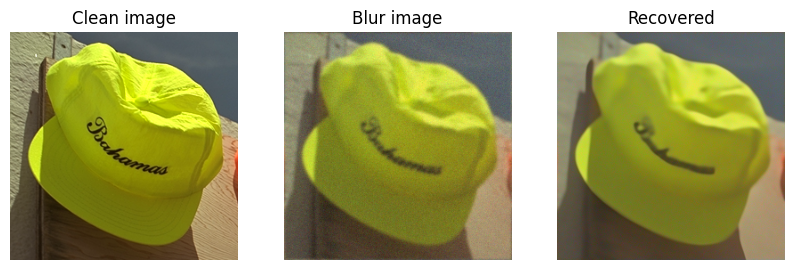

In [28]:
import scipy.io as scio
im_ycbr[:,:, 0] = x1_out
x1_out = ycbcr2rgb(im_ycbr)
x1_out = single2uint(x1_out)
if task == 'Gaussian-blurring':
    save_path = 'results/'+str(noise_level)+'_Gaussian_blur/'
    if not os.path.exists(save_path):
        mkdir(save_path)
    save_IR_name = save_path+name+'_'+task+'_'+algorithm+'_IR.png'
    save_degraded_name = save_path+name+'_deg.png'
    imsave(x1_out,save_IR_name)
    imsave(np.uint8(norm_proj(init_im)*255),save_degraded_name)
elif task == 'uniform-blurring':
    save_path = 'results/'+str(noise_level)+'_uniform_blur/'
    if not os.path.exists(save_path):
        mkdir(save_path)
    save_IR_name = save_path+name+'_'+task+'_'+algorithm+'_IR.png'
    save_degraded_name = save_path+name+'_deg.png'
    imsave(x1_out,save_IR_name)
    imsave(np.uint8(norm_proj(init_im)*255),save_degraded_name)
psnr_luma = calculate_psnr(x_gt_luma,x_est_luma)#####matlab psnr function
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10*1, 16*3))
ax[0].imshow(input_im)
ax[0].set_title('Clean image')
ax[0].set_axis_off()
ax[1].imshow(np.uint8(norm_proj(init_im)*255))
ax[1].set_title('Blur image')
ax[1].set_axis_off()
ax[2].imshow(x1_out)
ax[2].set_title('Recovered')
ax[2].set_axis_off()